In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.linear_model import LinearRegression
import numpy as np
plt.rcParams['font.family'] = 'Nanum Gothic'
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
import folium

In [4]:
file_path = '/Users/leejeje/Desktop/2024 겨울학기/Data Science Lab/EDA Project/Datasets/Data_Univ/0102.대학교개황(09-22)(100%).csv'
data_college = pd.read_csv(file_path, encoding='euc-kr') 
data_college = data_college[data_college["학교구분명"] == "대학"]
keep_values = ['대학', '산업대학', '교육대학', '기술대학(대학과정)', '기술대학(전문대학과정)']
data_college = data_college[data_college["학제유형명"].isin(keep_values)]
data_college = data_college[['조사년도', '학교명', '시도명', '학제유형명', '대학교개황_입학생수', '대학교개황_재학생수', '대학교개황_재적학생수']]
print(data_college.head())

   조사년도      학교명 시도명 학제유형명  대학교개황_입학생수  대학교개황_재학생수  대학교개황_재적학생수
0  2009  광주여자대학교  광주    대학        1121        3702         3988
1  2009    호원대학교  전북  산업대학        1509        5615         8963
2  2009    우송대학교  대전  산업대학           0        4911         8904
3  2009    삼육대학교  서울    대학        1398        4870         6667
5  2009   선교청대학교  충남    대학          64         167          213


In [5]:
predictions = []

for school in data_college['학교명'].unique():
    school_data = data_college[data_college['학교명'] == school]
    school_data = school_data[(school_data['조사년도'] < 2014) | (school_data['조사년도'] > 2015)]
    
    if school_data.shape[0] > 1:
        X = school_data['조사년도'].values.reshape(-1, 1)  
        y = school_data['대학교개황_입학생수'].values      
        
        model = LinearRegression()
        model.fit(X, y)
        
        years_to_predict = np.array([2014, 2015]).reshape(-1, 1)
        predicted_values = model.predict(years_to_predict)
        
        predictions.append({
            '학교명': school,
            '2014년_입학생수_예측': max(0, round(predicted_values[0])), 
            '2015년_입학생수_예측': max(0, round(predicted_values[1])) 
        })

predicted_df = pd.DataFrame(predictions)

print(predicted_df)

           학교명  2014년_입학생수_예측  2015년_입학생수_예측
0      광주여자대학교           1033           1017
1        호원대학교           1390           1380
2        우송대학교           1190           1192
3        삼육대학교           1319           1304
4       선교청대학교             12              0
..         ...            ...            ...
211    한국공학대학교           1630           1642
212      창신대학교            545            532
213      신한대학교           1578           1574
214  한국전통문화대학교            133            135
215  대구경북과학기술원            195            198

[216 rows x 3 columns]


In [6]:

data_college.loc[
    (data_college['조사년도'].isin([2014, 2015])), '대학교개황_입학생수'
] = None


for _, row in predicted_df.iterrows():
    for year in [2014, 2015]:
        data_college.loc[
            (data_college['조사년도'] == year) & (data_college['학교명'] == row['학교명']), 
            '대학교개황_입학생수'
        ] = row[f'{year}년_입학생수_예측']

print(data_college[data_college['조사년도'].isin([2014, 2015])].head(20))

      조사년도         학교명 시도명 학제유형명  대학교개황_입학생수  대학교개황_재학생수  대학교개황_재적학생수
1476  2014     광주여자대학교  광주    대학      1033.0        4303         4729
1477  2014       호원대학교  전북  산업대학      1390.0        6208         8636
1478  2014       우송대학교  대전  산업대학      1190.0           1           30
1479  2014     한경국립대학교  경기    대학      1359.0        3191         5036
1480  2014       삼육대학교  서울    대학      1319.0        6947         9859
1482  2014  광주대학교(산업대)  광주  산업대학         0.0           0            0
1483  2014       연세대학교  강원    대학      2808.0        9678        14201
1484  2014       연세대학교  서울    대학      2808.0       22115        32210
1485  2014       전남대학교  광주    대학      2258.0       20517        31040
1486  2014       전남대학교  전남    대학      2258.0        3810         6522
1490  2014       신한대학교  경기    대학      1578.0        2875         3774
1491  2014       대구대학교  경북    대학      3789.0       23037        35943
1492  2014       경운대학교  경북    대학       895.0        3168         4951
1493  2014  아세아연합신학대

In [7]:
data_college = data_college[['조사년도', '학교명', '시도명', '대학교개황_입학생수']]
print(data_college.head())  


   조사년도      학교명 시도명  대학교개황_입학생수
0  2009  광주여자대학교  광주      1121.0
1  2009    호원대학교  전북      1509.0
2  2009    우송대학교  대전         0.0
3  2009    삼육대학교  서울      1398.0
5  2009   선교청대학교  충남        64.0


In [8]:
data_school_by_year = {year: data_college[data_college["조사년도"] == year] for year in range(2009, 2023)}

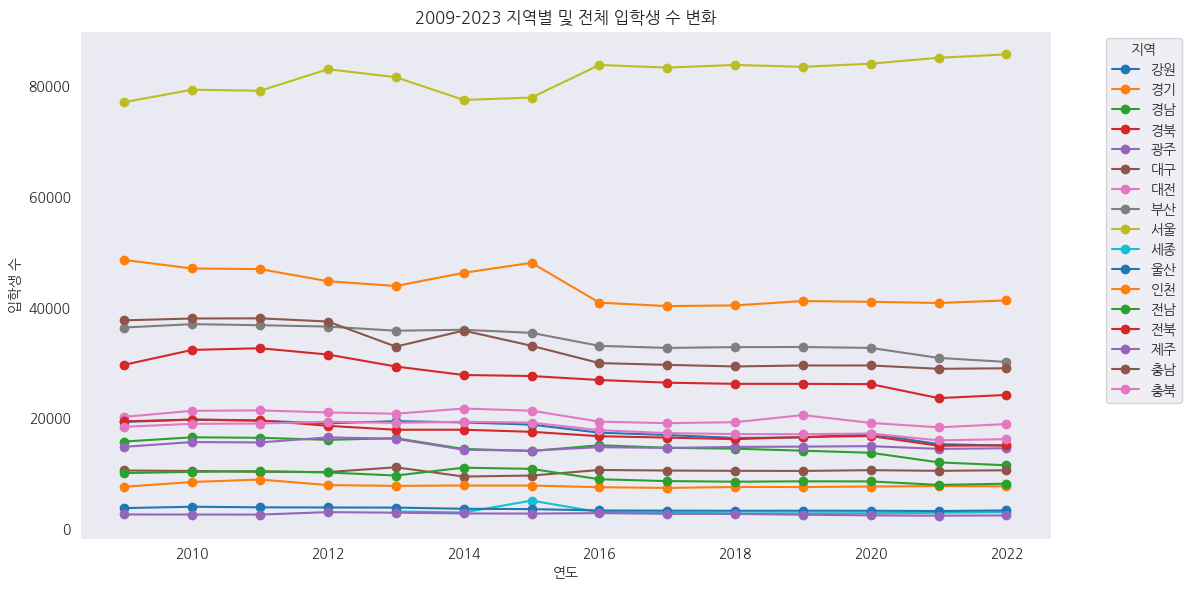

In [9]:
yearly_data = []

for year, df in data_school_by_year.items():
    grouped = df.groupby("시도명")["대학교개황_입학생수"].sum()
    yearly_data.append((year, grouped))

result = pd.DataFrame({
    year: data for year, data in yearly_data
}).T

plt.figure(figsize=(12, 6))

for region in result.columns:
    plt.plot(result.index, result[region], marker="o", label=region)

plt.title("2009-2023 지역별 및 전체 입학생 수 변화")
plt.xlabel("연도")
plt.ylabel("입학생 수")
plt.legend(title="지역", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.tight_layout()
plt.show()

In [10]:
import folium
import pandas as pd

locations = {
    "서울": (37.5665, 126.9780),
    "부산": (35.1796, 129.0756),
    "대구": (35.8714, 128.6014),
    "인천": (37.4563, 126.7052),
    "광주": (35.1595, 126.8526),
    "대전": (36.3504, 127.3845),
    "울산": (35.5384, 129.3114),
    "세종": (36.4800, 127.2890),
    "경기": (37.4138, 127.5183),
    "강원": (37.8228, 128.1555),
    "충북": (36.6356, 127.4913),
    "충남": (36.5184, 126.8000),
    "전북": (35.8175, 127.1116),
    "전남": (34.8161, 126.4629),
    "경북": (36.5745, 128.2043),
    "경남": (35.2383, 128.6922),
    "제주": (33.4996, 126.5312)
}
print(data_college.head())
df = pd.DataFrame(data_college)
print(df.head())
grouped_data = df.groupby(['조사년도', '시도명'])['대학교개황_입학생수'].sum().reset_index()
print(grouped_data.head())
years = grouped_data['조사년도'].unique()

for year in years:
    year_data = grouped_data[grouped_data['조사년도'] == year]
    
    m = folium.Map(location=[36.5, 127.5], zoom_start=7)
    
    for _, row in year_data.iterrows():
        location = locations[row['시도명']]
        folium.CircleMarker(
            location=location,
            radius=row['대학교개황_입학생수'] / 1000,  # 입학생 수에 비례한 크기
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            popup=f"{row['시도명']} ({row['대학교개황_입학생수']}명)"
        ).add_to(m)
    
    map_filename = f"university_map_{year}.html"
    m.save(map_filename)
    print(f"{year}년 지도가 {map_filename}로 저장되었습니다.")

   조사년도      학교명 시도명  대학교개황_입학생수
0  2009  광주여자대학교  광주      1121.0
1  2009    호원대학교  전북      1509.0
2  2009    우송대학교  대전         0.0
3  2009    삼육대학교  서울      1398.0
5  2009   선교청대학교  충남        64.0
   조사년도      학교명 시도명  대학교개황_입학생수
0  2009  광주여자대학교  광주      1121.0
1  2009    호원대학교  전북      1509.0
2  2009    우송대학교  대전         0.0
3  2009    삼육대학교  서울      1398.0
5  2009   선교청대학교  충남        64.0
   조사년도 시도명  대학교개황_입학생수
0  2009  강원     19353.0
1  2009  경기     48632.0
2  2009  경남     15800.0
3  2009  경북     29682.0
4  2009  광주     14842.0
2009년 지도가 university_map_2009.html로 저장되었습니다.
2010년 지도가 university_map_2010.html로 저장되었습니다.
2011년 지도가 university_map_2011.html로 저장되었습니다.
2012년 지도가 university_map_2012.html로 저장되었습니다.
2013년 지도가 university_map_2013.html로 저장되었습니다.
2014년 지도가 university_map_2014.html로 저장되었습니다.
2015년 지도가 university_map_2015.html로 저장되었습니다.
2016년 지도가 university_map_2016.html로 저장되었습니다.
2017년 지도가 university_map_2017.html로 저장되었습니다.
2018년 지도가 university_map_2018.html로 저장되었습니다.
2019년 지도가 

In [13]:
import dash
from dash import dcc, html
import glob

html_files = glob.glob("university_map_*.html")
html_files.sort() 

years = [file.split("_")[-1].split(".")[0] for file in html_files]

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("연도별 대학교 입학생 수", style={'textAlign': 'center'}),
    html.Div(id='year-display', style={'textAlign': 'center', 'fontSize': 24, 'marginBottom': '20px'}),
    dcc.Interval(
        id='interval-component',
        interval=1000,  
        n_intervals=0
    ),
    html.Iframe(
        id='iframe',
        srcDoc=open(html_files[0], 'r').read(),
        width='100%',
        height='600'
    )
])

@app.callback(
    [dash.dependencies.Output('iframe', 'srcDoc'),
     dash.dependencies.Output('year-display', 'children'),
     dash.dependencies.Output('interval-component', 'disabled')],
    [dash.dependencies.Input('interval-component', 'n_intervals')]
)
def update_map(n_intervals):
    index = n_intervals % len(html_files)
    current_file = html_files[index]
    current_year = years[index]
    stop = n_intervals >= len(html_files) - 1
    
    return open(current_file, 'r').read(), f"Displaying Year: {current_year}", stop

if __name__ == '__main__':
    app.run_server(debug=True, port = 8053)